# Module 1: Introduction to Exploratory Data Analysis 

In this notebook we dive into some plotting methods commonly used for Exploratory Data Analysis (EDA). 

Our goals for EDA are to open-mindedly explore the data, and see what insights we may find. 

The purpose of the EDA approach is to:
- maximize insight into a data set
- uncover underlying structure
- extract important variables
- detect outliers and anomalies
- test underlying assumptions
- develop parsimonious models
- determine optimal factor settings

In this notebook we'll investigate these plotting techniques:

1. Scatter Plot
1. Scatter Matrix
1. Histogram
1. Bar Plot
1. Box Plot
1. Time Series

### Setup
<a id='setup'></a>

In [94]:
from datetime import datetime
import dateutil.parser
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# The command below means that the output of multiple commands in a cell will be output at once
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# The command below tells jupyter to display up to 80 columns, this keeps everything visible
pd.set_option('display.max_columns', 80)
pd.set_option('expand_frame_repr', True)

sns.set_palette("hls")
%matplotlib inline

With each notebook, we need to read in our dataset

In [95]:
path = '../data/'
filename = 'loans.csv'
df = pd.read_csv(path+filename)

Before diving into our exploratory data analysis, it is worth reiterating that this whole process is about understanding the distribution of data and relationships between different features.

When we move on to use machine learning algorithms, we will be asking a question and trying to answer it using the statistical relationships between different features in the data. The EDA analysis will help us shape this question and have a clear idea about how to approach building the algorithm!

With that in mind, let's look at several visualization methods to examine the data and any relationships between features…

### 1. Scatter plot

To start, the scatter plot! This is a very popular and powerful way to visualize the relationship between two continuous features. Essentially this plot shows us how feature Y changes when feature X is changed. If there is a clear pattern formed in the scatter plot, we say that x and y are **correlated**. 

There are several outcomes we see on a scatter plot:
- Positive Linear = When X increases, y increases and the data points follow an approximate straight line
- Negative Linear = When X increase, y decreases and the data points follow an approximate straight line
- Non-Linear = When X increases, there is a consistent change in Y but this is not linear. It could be quadratic or exponential for example. 
- No correlation = When X increases, there is no clear pattern to how y changes, The data points form a random distribution.

Let's try this out on our data and choose two continuous variables to plot. First lets extract all the continuous variables from our dataset.

In [96]:
numeric_vars = df.select_dtypes(include=[np.number]).columns.tolist()
for variable in numeric_vars:
    print(variable)

id_number
loan_amount
lender_count
funded_amount
repayment_term


To start, let's look if there is a relationship between lender_count and loan_amount... intuition suggests that bigger loans much have more lenders. If this is true, we'll see this in the scatter plot!

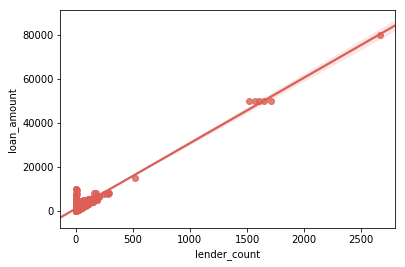

In [97]:
ax = sns.regplot(x='lender_count', y='loan_amount', data=df)

Where does the data follow the line?

Where does the data __not__ follow the line?

What are possible reasons that data does __not__ follow the line?

-----
Let's explore another relationship.
------

How about the repayment term and the loan amount? 

What kind of relationship would you expect between the repayment term and the loan amount?

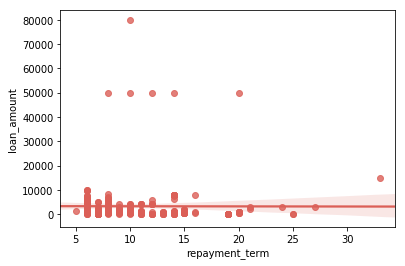

In [98]:
ax = sns.regplot(x='repayment_term', 
                 y='loan_amount', 
                 data=df)

Where does the data follow the line?

Where does the data __not__ follow the line?

What are possible reasons that data does __not__ follow the line?

### 2. Scatter Matrix

When we have lots of continuous variables, we could go through them one by one to see the relationship or we could use a scatterplot matrix! This creates a scatter plot between every combination of variables in a list. 

Another interesting quality of the scatter matrix is that the diagonals give a histogram of the variable in question. 

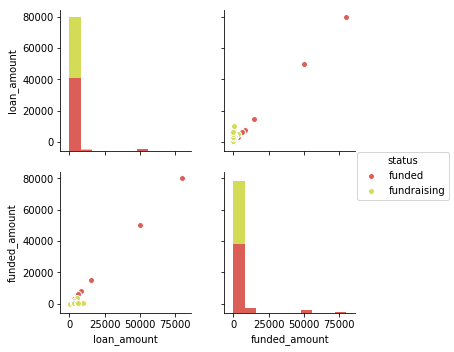

In [99]:
# Let's choose only a couple of columns to examine:
columns = ['loan_amount', 'funded_amount',  'status']
num_df = df[columns]

# Remove the NaN rows so Seaborn can plot
num_df = num_df.dropna(axis=0, how='any')

# Create the scatter plot and let's color the data point by their status.
sns.pairplot(num_df, hue='status');

What can say about the data?

<br>
<br>
<br>

### 4. Histogram

A histogram is useful for looking at the distribution of values for a single variable and also identifying outliers. It shows us the count of data.

The plot below shows the data distribution of loan_amount using both bars and a continuous line. Without going into too much detail about the value on the y-axis, what we can take away from this is there is a much higher occurrence of small loans (high bar/peak in the line) and that large loans are much rarer (low bars/drop in the line).

/Users/brian/anaconda3/envs/good/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


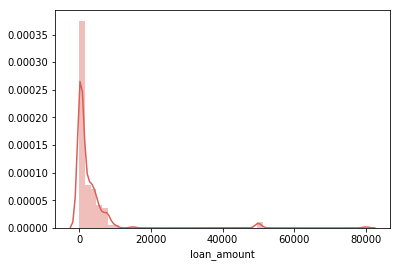

In [100]:
sns.distplot(df['loan_amount'].dropna(axis = 0));

/Users/brian/anaconda3/envs/good/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


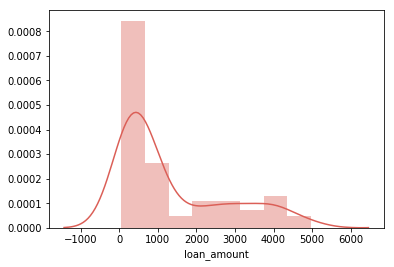

In [101]:
# Let's just look at those under 5K
small_loans_df = df[(df['loan_amount'] < 5000)]
sns.distplot(small_loans_df['loan_amount']);

Looking at the loans less than 5000 we see a much clearer distribution, although it is still left-hand skewed. 

### 5. Bar Plot

Bar plots are useful for understanding how categorical groups are different with respect to a continuous variable.


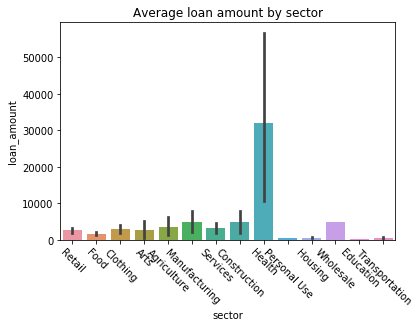

In [102]:
p = sns.barplot(x='sector', y = 'loan_amount', data=df, estimator=np.mean);
p.set(title='Average loan amount by sector')
p.set_xticklabels(p.get_xticklabels(), rotation=-45);

Which sector is the largest? Why?

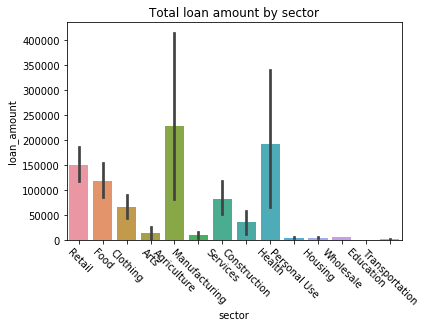

In [103]:
p = sns.barplot(x='sector', y = 'loan_amount', data=df, estimator=np.sum);
p.set(title='Total loan amount by sector')
p.set_xticklabels(p.get_xticklabels(), rotation=-45);

Which sector is the largest? Why?

<br>
<br>

### 6. Box Plots

A box plot describes the distribution of data based on five important summary numbers: the minimum, first quartile, median, third quartile, and maximum. In the simplest box plot the central rectangle spans the first quartile to the third quartile (the interquartile range or IQR). A segment inside the rectangle shows the median and "whiskers" above and below the box show the locations of the minimum and maximum. 

Lets use this to look at the distribution of borrowers counts by each sector for different loan status for different partners. First lets look at how many loans come from different partners.

In [104]:
df_retail = df[df.sector=='Retail']
df_retail.head()

,id_number,loan_amount,lender_count,status,funded_date,funded_amount,repayment_term,location_country_code,sector,description_texts_en,use
0,736066,4825,60,funded,2014-08-03T17:51:50Z,4825,8,BJ,Retail,NaN,NaN
2,743238,400,10,funded,2014-08-17T22:03:01Z,400,14,BJ,Retail,NaN,NaN
3,744232,5850,176,funded,2014-08-26T22:16:21Z,5850,12,BJ,Retail,NaN,NaN
5,744240,500,13,funded,2014-08-20T01:26:40Z,500,10,BJ,Retail,NaN,NaN
6,744243,1000,31,funded,2014-08-26T10:01:10Z,1000,13,BJ,Retail,NaN,NaN


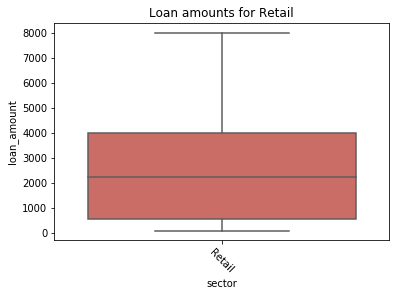

In [105]:
sector = 'Retail'
df_retail = df[df.sector==sector]
p = sns.boxplot(x='sector', 
                y='loan_amount',
                data=df_retail);
p.set(title = f'Loan amounts for {sector}');
p.set_xticklabels(p.get_xticklabels(), rotation=-45);

Try this - Select other sectors and see how they look

Aha! It looks like we are onto something here... we can see different trends for different partners! We'll look into this further in feature_engineering to see how we can use to create powerful features. 

### 7. Time dependancy
Quite often it's useful to see how a variable changes over time. This means creating a plot with time on the x-axis and the variable on the y-axis.

Lets have a look at how the average loan amount changes over time on a monthly basis.

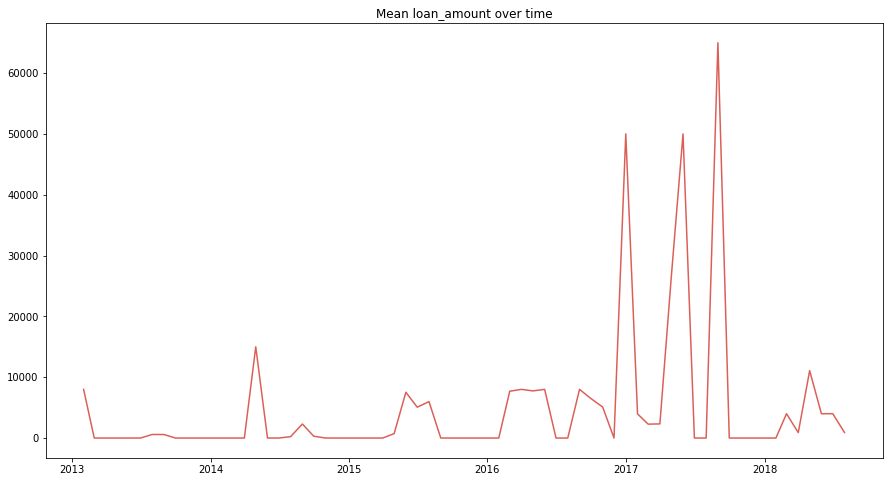

In [106]:
# Convert posted date to a datetime object
time_column = 'funded_date'
df[time_column] = pd.to_datetime(df[time_column])
# Resample the date to monthly intervals , taking the mean of loan_amount
# This creates an array where the index is the timestamp and the value is the mean of loan amount
time_data = df.resample('M', on=time_column)['loan_amount'].mean().fillna(0)
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(time_data)
plt.title('Mean loan_amount over time');

We can look at different timefrance by changing the parameter in resample. Lets look on a weekly basis!

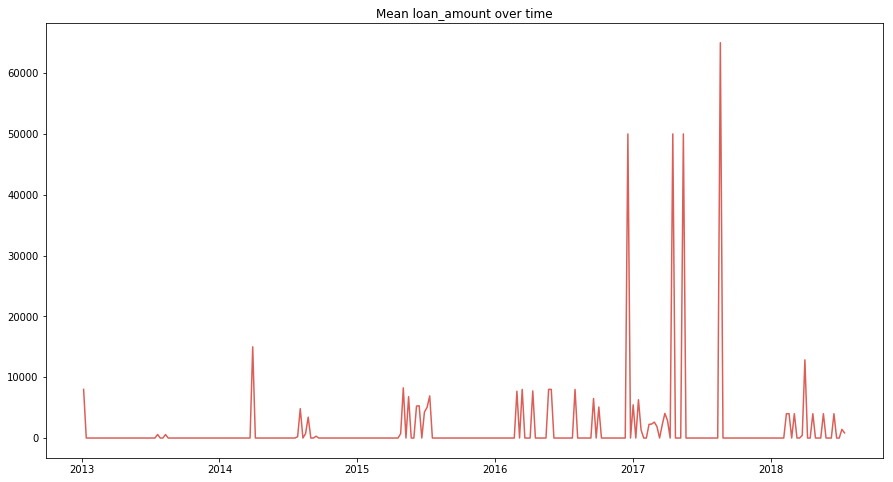

In [107]:
# Resample the date to monthly intervals , taking the mean of loan_amount
# This creates an array where the index is the timestamp and the value is the mean of loan amount
time_data = df.resample('7D', on=time_column)['loan_amount'].mean().fillna(0)
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(time_data)
plt.title('Mean loan_amount over time');

### Moving on

Next we move on to feature engineering, where we create variables from what we've found!

<br>
<br> 
<br>

----